# (1) 라이브러리 불러오기

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
from statsmodels.graphics.mosaicplot import mosaic      #mosaic plot!
import joblib

#한글 폰트 지정
import matplotlib.font_manager as fm

# 설치된 폰트
font_list = [font.name for font in fm.fontManager.ttflist]

# 맑은 고딕이 있는지 확인
'Malgun Gothic' in font_list

plt.rcParams['font.family'] = 'Malgun Gothic'

- colab 작업용: 경로 커스터마이징 필요(편하신 대로 사용하세요)

In [252]:
# from google.colab import drive
# drive.mount('/content/drive')

# (2) 데이터 불러오기
1. 전남 총 인구수 = '2024_전라남도_인구_추계.csv'
2. 전남 폐교 수 = '2024_전라남도교육청_폐교재산기본정보.csv'
3. 전국 학교 학생수 현황 = '2024_초등학교_전라남도.csv'

In [253]:
# import os
# print("현재 작업 디렉토리:", os.getcwd())  # 현재 작업 디렉토리 출력

In [254]:
# 로컬 경로 (다운받아 사용하신다면 수정해서 사용하세요 )
path = 'origin_data/'

In [255]:
file = '2024_전라남도_인구_추계.csv'
data01= pd.read_csv(path + file)
# data01.head()

In [256]:
file = '2024_전라남도교육청_폐교재산기본정보.csv'
data02= pd.read_csv(path + file)
# data02.head()

In [257]:
file = '2024_전국초등학교.csv'
data03 = pd.read_csv(path + file)
# data03.head()

In [258]:
file = '전국학원교습소정보(교육부,2024).csv'
data04 = pd.read_csv(path + file)
#data04.head()

# (3) 데이터 전처리

In [259]:
# 데이터 복사 (원본 데이터를 지키도록 )
data_total_human= data01.copy()  # 총 인구수
data_close_school = data02.copy() # 폐교 학교
data_total_school = data03.copy() # 전국 학교
data_coding_academy = data04.copy() # 전국 코딩학원

### 1) 총 인구수 전처리 (data_total_human)
- 1. xlsx > csv 파일로 변환하는 과정에서 삭제된 행 (전부 NA로 구성) 이 표기되는 문제   
- 2. 중간에 인구수가 비어있는 경우 [-1 년도]~ [+1년도] 의 합 평균으로 대체
- 3. 결측치가 있어서 float 으로 표기되는 문제 > int로 변환

In [260]:
# data_total

In [261]:
# 전라남도 총 인구수
# 1. 결측치 제거 (행이 전부 NA )
data_total_human = data_total_human.dropna(axis=0,how='all')
# data_total

In [262]:
# 2. 2015년부터 2040년까지의 결측치를 이전 년도와 이후 년도의 평균값으로 채우기
for year in range(2015, 2040):
    year_str = str(year)
    next_year_str = str(year + 1) if year + 1 <= 2040 else None
    prev_year_str = str(year - 1) if year - 1 >= 2015 else None

    for index, row in data_total_human.iterrows():
        if pd.isna(row[year_str]):  # 해당 연도의 값이 결측치일 경우
            prev_value = data_total_human.at[index, prev_year_str] if prev_year_str else None
            next_value = data_total_human.at[index, next_year_str] if next_year_str else None

            # 이전 년도와 이후 년도의 평균으로 결측치를 채움
            if prev_value is not None and next_value is not None:
                data_total_human.at[index, year_str] = (prev_value + next_value) / 2
            elif prev_value is not None:
                data_total_human.at[index, year_str] = prev_value
            elif next_value is not None:
                data_total_human.at[index, year_str] = next_value

# data_total.isna().sum()

In [263]:
cols_to_convert = [str(year) for year in range(2015, 2041)]  # 2015~2040 열 선택
data_total_human[cols_to_convert] = data_total_human[cols_to_convert].astype(int) # 정수로 변환

# data_total.head()
# 결측치 수 확인
# data_total.isna().sum()결측치 수 확인-

### 2) 폐교 데이터 전처리 (data_close_school)
1. 삭제할 컬럼들을 제거

In [264]:
# 삭제할 컬럼
drop_cols = ['시도교육청명','시도교육청코드','교육지원청코드','교육지원청명','시도코드','시도명','시군구코드','담당자 부서명','담당자 전화번호','소재지도로명주소','소재지지번주소','데이터기준일자']

data_close_school=data_close_school.drop(columns=drop_cols)

data_close_school

,시군구명,폐교명,폐교연도,학교급구분명,활용현황구분명,건물연면적,대지
0,강진군,강진서초영파분교장,1991,초등학교,미활용,0,9250
1,강진군,강진북초등학교,2024,초등학교,미활용,2346,20534
2,고흥군,과역동초백일분교장,2007,초등학교,미활용,211,5056
3,고흥군,나로고등학교,2014,고등학교,미활용,3473,21377
4,고흥군,동강초매곡분교장,1997,초등학교,미활용,1130,13278
...,...,...,...,...,...,...,...
112,화순군,아산초노치분교장,1994,초등학교,미활용,106,3309
113,화순군,동면초옥호분교장,1995,초등학교,미활용,289,3465
114,화순군,아산초송방분교장,1996,초등학교,미활용,835,7100
115,화순군,화순초수만분교장,1997,초등학교,미활용,362,5014


### 3) 전국 작은학교 데이터 전처리 (data_total_school)
1. 삭제할 컬럼 제거
2. '학급수(계)'와 '학생수(계)'에서 괄호와 숫자를 제거

In [265]:
# data_total_school

In [266]:
drop_cols = ['정보공시 학교코드','학교급코드','제외여부','제외사유']

data_total_school=data_total_school.drop(columns=drop_cols)

data_total_school.head()

,시도교육청,교육지원청,지역,학교명,설립구분,1학년,2학년,3학년,4학년,5학년,6학년,특수학급,순회학급,학급수(계),학생수(계),학급당학생수
0,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 서초구,서울교육대학교부설초등학교,국립,4,4,4,5,5,5,1,0,28(1),611(5),21.8
1,서울특별시교육청,서울특별시중부교육지원청,서울특별시 종로구,서울대학교사범대학부설초등학교,국립,5,5,5,5,5,5,1,0,31(1),576(6),18.6
2,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,서울개원초등학교,공립,7,4,5,4,5,4,1,0,30(1),868(8),28.9
3,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,서울개일초등학교,공립,5,5,6,5,6,6,0,0,33(0),967(0),29.3
4,서울특별시교육청,서울특별시강남서초교육지원청,서울특별시 강남구,서울개포초등학교,공립,8,7,6,7,7,7,2,0,44(2),903(4),20.5


In [267]:
# '학급수(계)'와 '학생수(계)'에서 괄호와 숫자를 제거
data_total_school['학급수(계)'] = data_total_school['학급수(계)'].str.extract('(\d+)')  # 괄호 안 숫자 제거하고 숫자만 추출
data_total_school['학생수(계)'] = data_total_school['학생수(계)'].str.extract('(\d+)')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\User\AppData\Local\Temp\ipykernel_13820\3530519482.py:2: SyntaxWarning: invalid escape sequence '\d'
  data_total_school['학급수(계)'] = data_total_school['학급수(계)'].str.extract('(\d+)')  # 괄호 안 숫자 제거하고 숫자만 추출
C:\Users\User\AppData\Local\Temp\ipykernel_13820\3530519482.py:3: SyntaxWarning: invalid escape sequence '\d'
  data_total_school['학생수(계)'] = data_total_school['학생수(계)'].str.extract('(\d+)')


In [268]:
data_total_school.dtypes

시도교육청      object
교육지원청      object
지역         object
학교명        object
설립구분       object
1학년         int64
2학년         int64
3학년         int64
4학년         int64
5학년         int64
6학년         int64
특수학급        int64
순회학급        int64
학급수(계)     object
학생수(계)     object
학급당학생수    float64
dtype: object

In [269]:
# 작은학교 여부(전교생 60명 이하) 컬럼 생성
# '학생수(계)'가 60명 이하인지 여부를 판단하여 '작은학교여부' 컬럼 생성
data_total_school['작은학교여부'] = data_total_school['학생수(계)'].astype(int).apply(lambda x: 1 if x <= 60 else 0)

In [270]:
# '지역' 컬럼을 '시'와 '구'로 분리하기 위해 '지역'의 첫 번째 부분을 '시'로, 두 번째 부분을 '구'로 분리
data_total_school[['지역(시)', '지역(구)']] = data_total_school['지역'].str.extract(r'([^\s]+)\s(.*)')

drop_cols = '지역'

data_total_school=data_total_school.drop(columns= drop_cols)

In [271]:
data_total_school.head()

,시도교육청,교육지원청,학교명,설립구분,1학년,2학년,3학년,4학년,5학년,6학년,특수학급,순회학급,학급수(계),학생수(계),학급당학생수,작은학교여부,지역(시),지역(구)
0,서울특별시교육청,서울특별시강남서초교육지원청,서울교육대학교부설초등학교,국립,4,4,4,5,5,5,1,0,28,611,21.8,0,서울특별시,서초구
1,서울특별시교육청,서울특별시중부교육지원청,서울대학교사범대학부설초등학교,국립,5,5,5,5,5,5,1,0,31,576,18.6,0,서울특별시,종로구
2,서울특별시교육청,서울특별시강남서초교육지원청,서울개원초등학교,공립,7,4,5,4,5,4,1,0,30,868,28.9,0,서울특별시,강남구
3,서울특별시교육청,서울특별시강남서초교육지원청,서울개일초등학교,공립,5,5,6,5,6,6,0,0,33,967,29.3,0,서울특별시,강남구
4,서울특별시교육청,서울특별시강남서초교육지원청,서울개포초등학교,공립,8,7,6,7,7,7,2,0,44,903,20.5,0,서울특별시,강남구


### 4) 전남 작은학교 데이터 전처리(data_target_school)
1. 전국 학교 현황 데이터에서 , 시도교육청 ='전라남도교육청' 인 열들만  추출

In [272]:
# '시도교육청'이 '전라남도교육청'인 행만 필터링
data_target_school = data_total_school[data_total_school['시도교육청'] == '전라남도교육청']
data_target_school.head()

,시도교육청,교육지원청,학교명,설립구분,1학년,2학년,3학년,4학년,5학년,6학년,특수학급,순회학급,학급수(계),학생수(계),학급당학생수,작은학교여부,지역(시),지역(구)
4722,전라남도교육청,전라남도목포교육지원청,광주교육대학교목포부설초등학교,국립,3,3,3,3,3,3,1,0,19,394,20.7,0,전라남도,목포시
4723,전라남도교육청,전라남도강진교육지원청,강진동초등학교,공립,1,1,1,1,1,1,1,0,7,54,7.7,1,전라남도,강진군
4724,전라남도교육청,전라남도강진교육지원청,강진중앙초등학교,공립,5,5,6,5,4,4,1,0,30,608,20.3,0,전라남도,강진군
4725,전라남도교육청,전라남도강진교육지원청,계산초등학교,공립,1,1,1,1,1,1,1,0,7,52,7.4,1,전라남도,강진군
4726,전라남도교육청,전라남도강진교육지원청,군동초등학교,공립,1,1,1,1,1,1,1,0,7,30,4.3,1,전라남도,강진군


### 5) 전국 코딩학원 현황 (data_coding_academy)
1. 지역별 코딩학원 개수(= IT 교육시설) 차이를 시각화 하기 위함   [주로 서울특별시 vs 전라남도]
2. 필요없는 컬럼 삭제 (수정일자, 전화번호, 수저일자, 도로명)  : 다시 생각해보니까 전부 쓸모없는 데이터들인데 삭제하진 말고 종합 결과만 보여주자

In [273]:
data_coding_academy.head()

,시도교육청코드,시도교육청명,행정구역명,학원교습소명,학원지정번호,학원명,개설일자,등록일자,등록상태명,휴원시작일자,...,교습과정목록명,교습과정명,인당수강료,수강료공개여부,기숙사학원여부,도로명주소,도로명상세주소,도로명우편번호,전화번호,수정일자
0,B10,서울특별시교육청,강남구,학원,3000038262,더알고리즘(The Rgorithm)학원,20210118,20210118,개원,,...,"정보교과,",정보교과,,Y,N,서울특별시 강남구 압구정로 156,", 207호 (신사동, 카로시티2빌딩)",6030,02-514-3697,20231018
1,B10,서울특별시교육청,강남구,학원,3000043235,로그엔코딩학원,20230206,20230206,개원,,...,정보교과,정보교과,,Y,N,서울특별시 강남구 언주로174길 17,", 3층 일부 북동측호 (신사동)",6017,02-540-1628,20241215
2,B10,서울특별시교육청,강동구,학원,3000051438,알콤학원,20241118,20241118,개원,,...,NaN,NaN,,Y,,서울특별시 강동구 풍성로54길 56,3층 (성내동),5403,NaN,20241215
3,B10,서울특별시교육청,강북구,교습소,3000050952,코리코딩교습소,20240816,20240816,개원,,...,NaN,NaN,,Y,,서울특별시 강북구 솔샘로 167,벽산라이브파크 상가동 129-1호(미아동),1191,02-0000-0000,20240908
4,B10,서울특별시교육청,광진구,학원,3000051233,디랩코딩광진학원,20241011,20241011,개원,,...,정보,정보,,Y,,서울특별시 광진구 광나루로54길 32,4층(구의동),5117,02-0000-0000,20241215


# (4) 사용할 데이터프레임 확인

1. data_total_human : 전남 인구수 추이(2015~ 2040)
2. data_close_school: 전남 폐교 학교 정보
3. data_total_school: 전국 학교 데이터
4. data_target_school: 전국 학교 데이터 중에서 '전라남도' 데이터  
5. data_coding_academy : 전국 코딩학원 (지역별) 총합 수 확인용용

In [274]:
data_total_human.head()

,연령별(1),2015,2016,2017,2018,2019,2020,2021,2022,2023,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040
0,계,1796578,1798310,1795036,1796331,1793043,1793108,1782951,1768620,1757262,...,1691353,1684207,1677115,1670005,1662850,1655614,1648264,1640703,1633004,1625140
1,0 - 4세,77867,75751,72465,67561,63060,58050,52933,48568,45151,...,40818,41390,41788,42009,42074,41917,41487,40834,40004,39045
2,5 - 9세,74456,76523,77976,77578,76746,76030,73677,69825,65221,...,37599,37228,37373,38202,39244,40134,40854,41397,41760,41956
3,10 - 14세,87395,80634,77662,76835,75156,76335,78074,78777,78122,...,50991,46919,43649,40820,38737,37795,37462,37686,38620,39766
4,15 - 19세,111225,108852,102937,97192,91205,84097,80653,78695,77682,...,72916,69098,64782,60692,55878,50718,46746,43530,40754,38751


In [275]:
data_close_school.head()

,시군구명,폐교명,폐교연도,학교급구분명,활용현황구분명,건물연면적,대지
0,강진군,강진서초영파분교장,1991,초등학교,미활용,0,9250
1,강진군,강진북초등학교,2024,초등학교,미활용,2346,20534
2,고흥군,과역동초백일분교장,2007,초등학교,미활용,211,5056
3,고흥군,나로고등학교,2014,고등학교,미활용,3473,21377
4,고흥군,동강초매곡분교장,1997,초등학교,미활용,1130,13278


In [276]:
data_total_school.head()

,시도교육청,교육지원청,학교명,설립구분,1학년,2학년,3학년,4학년,5학년,6학년,특수학급,순회학급,학급수(계),학생수(계),학급당학생수,작은학교여부,지역(시),지역(구)
0,서울특별시교육청,서울특별시강남서초교육지원청,서울교육대학교부설초등학교,국립,4,4,4,5,5,5,1,0,28,611,21.8,0,서울특별시,서초구
1,서울특별시교육청,서울특별시중부교육지원청,서울대학교사범대학부설초등학교,국립,5,5,5,5,5,5,1,0,31,576,18.6,0,서울특별시,종로구
2,서울특별시교육청,서울특별시강남서초교육지원청,서울개원초등학교,공립,7,4,5,4,5,4,1,0,30,868,28.9,0,서울특별시,강남구
3,서울특별시교육청,서울특별시강남서초교육지원청,서울개일초등학교,공립,5,5,6,5,6,6,0,0,33,967,29.3,0,서울특별시,강남구
4,서울특별시교육청,서울특별시강남서초교육지원청,서울개포초등학교,공립,8,7,6,7,7,7,2,0,44,903,20.5,0,서울특별시,강남구


In [277]:
data_target_school.head()

,시도교육청,교육지원청,학교명,설립구분,1학년,2학년,3학년,4학년,5학년,6학년,특수학급,순회학급,학급수(계),학생수(계),학급당학생수,작은학교여부,지역(시),지역(구)
4722,전라남도교육청,전라남도목포교육지원청,광주교육대학교목포부설초등학교,국립,3,3,3,3,3,3,1,0,19,394,20.7,0,전라남도,목포시
4723,전라남도교육청,전라남도강진교육지원청,강진동초등학교,공립,1,1,1,1,1,1,1,0,7,54,7.7,1,전라남도,강진군
4724,전라남도교육청,전라남도강진교육지원청,강진중앙초등학교,공립,5,5,6,5,4,4,1,0,30,608,20.3,0,전라남도,강진군
4725,전라남도교육청,전라남도강진교육지원청,계산초등학교,공립,1,1,1,1,1,1,1,0,7,52,7.4,1,전라남도,강진군
4726,전라남도교육청,전라남도강진교육지원청,군동초등학교,공립,1,1,1,1,1,1,1,0,7,30,4.3,1,전라남도,강진군


# (5) 데이터 시각화 (단변량 분석)
1. data_total_human : 전남 인구수 추이(2015~ 2040)
2. data_close_school: 전남 폐교 학교 정보
3. data_total_school: 전국 학교 데이터
4. data_target_school: 전국 학교 데이터 중에서 '전라남도' 데이터
5. data_coding_academy: 전국 코딩학원 현황


- 1) data_total_human : 전남 인구수 추이(나이대별 분석  - 주 타겟: 10~14세)

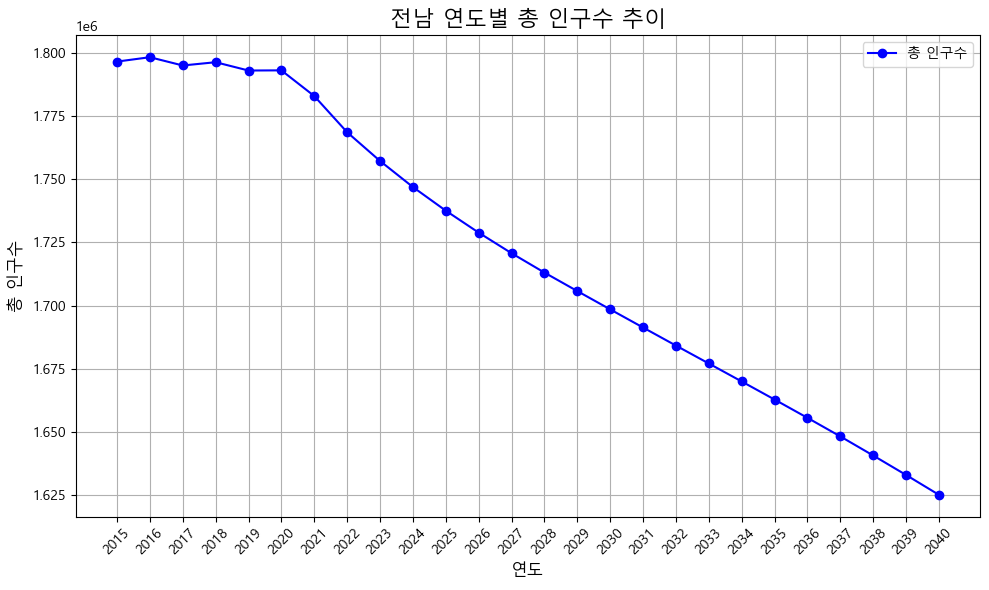

In [278]:
# 전남 인구수 추이

# 연도별 총 인구수 추이 (계)만 추출
total_population = data_total_human.loc[data_total_human['연령별(1)'] == '계'].drop('연령별(1)', axis=1).values.flatten()
# 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(data_total_human.columns[1:], total_population, marker='o', color='b', label='총 인구수')
plt.title('전남 연도별 총 인구수 추이', fontsize=16)
plt.xlabel('연도', fontsize=12)
plt.ylabel('총 인구수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


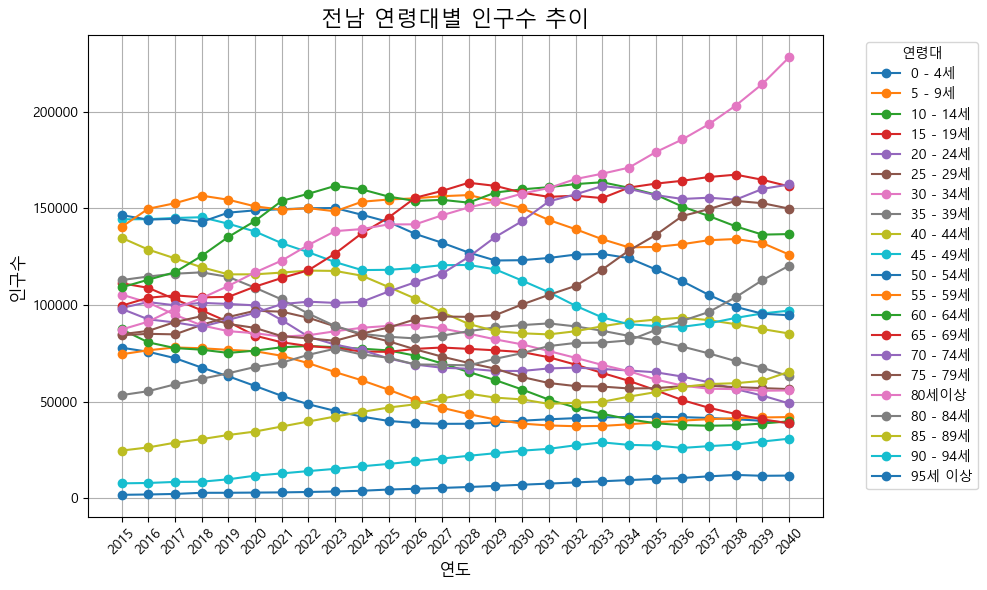

In [279]:
# 연령별 인구수 데이터만 추출
age_groups = data_total_human['연령별(1)'][1:]  # '계'를 제외한 연령대
age_population = data_total_human.drop('연령별(1)', axis=1).iloc[1:]  # 연령대별 인구수

# 각 연령대의 인구수 추이 그래프 그리기
plt.figure(figsize=(10, 6))

for i, age_group in enumerate(age_groups):
    plt.plot(data_total_human.columns[1:], age_population.iloc[i], marker='o', label=age_group)

plt.title('전남 연령대별 인구수 추이', fontsize=16)
plt.xlabel('연도', fontsize=12)
plt.ylabel('인구수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="연령대", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- 모든 연령대 중에서 10~14 대상 분포만 확인

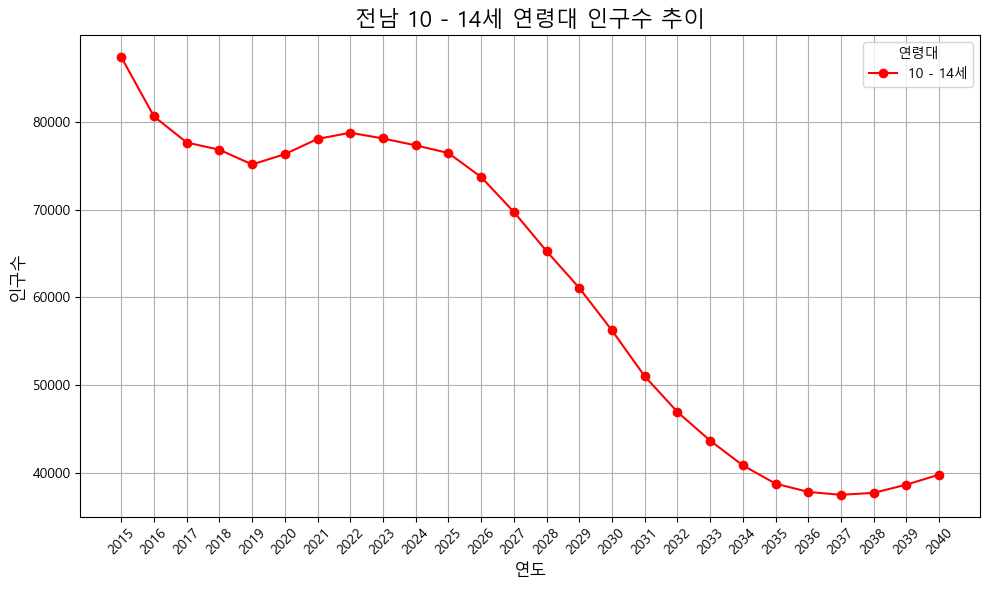

In [280]:
# 10 - 14세 연령대 추출
age_group_10_14 = data_total_human.loc[data_total_human['연령별(1)'] == '10 - 14세'].drop('연령별(1)', axis=1).values.flatten()
# 20 - 24세 연령대 추출
#age_group_20_24 = data_total_human.loc[data_total_human['연령별(1)'] == '20 - 24세'].drop('연령별(1)', axis=1).values.flatten()
# 65 - 69세세 연령대 추출
#age_group_65_69 = data_total_human.loc[data_total_human['연령별(1)'] == '65 - 69세'].drop('연령별(1)', axis=1).values.flatten()
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.title('전남 10 - 14세 연령대 인구수 추이', fontsize=16)
plt.plot(data_total_human.columns[1:], age_group_10_14, marker='o', color='r', label='10 - 14세')
#plt.plot(data_total_human.columns[1:], age_group_20_24, marker='o', color='g', label='20 - 24세')
#plt.plot(data_total_human.columns[1:], age_group_65_69, marker='o', color='b', label='65 - 69세')

plt.xlabel('연도', fontsize=12)
plt.ylabel('인구수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="연령대")
plt.tight_layout()
plt.show()

- 주요 타겟: 10~14 학생

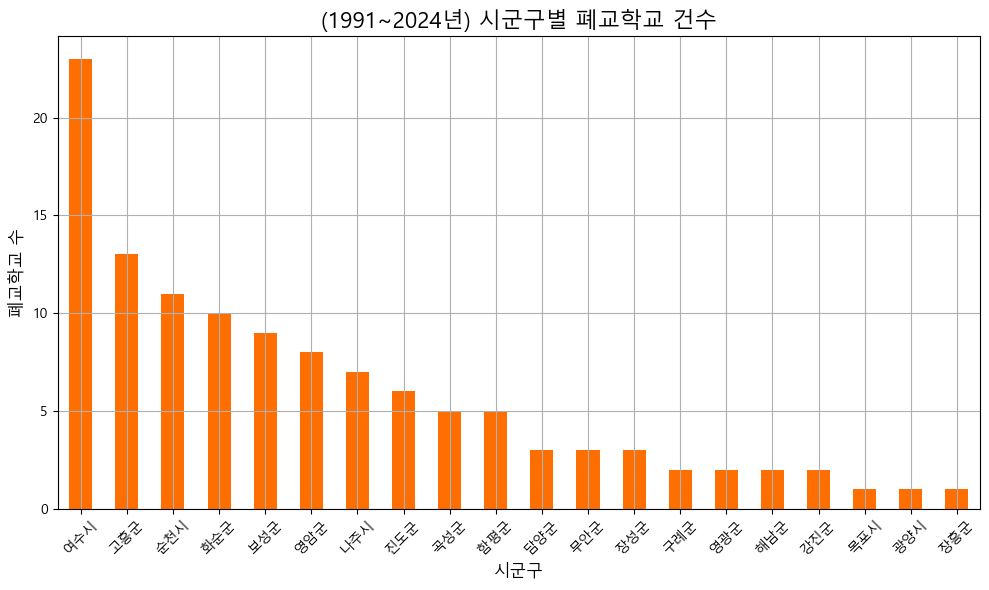

In [317]:
# 시군구별 폐교학교 수 계산
close_school_count = data_close_school['시군구명'].value_counts()

# 그래프 그리기
plt.figure(figsize=(10, 6))
close_school_count.plot(kind='bar', color='#FE6E00')

plt.title('(1991~2024년) 시군구별 폐교학교 건수', fontsize=16)
plt.xlabel('시군구', fontsize=12)
plt.ylabel('폐교학교 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
#035096
#FE6E00

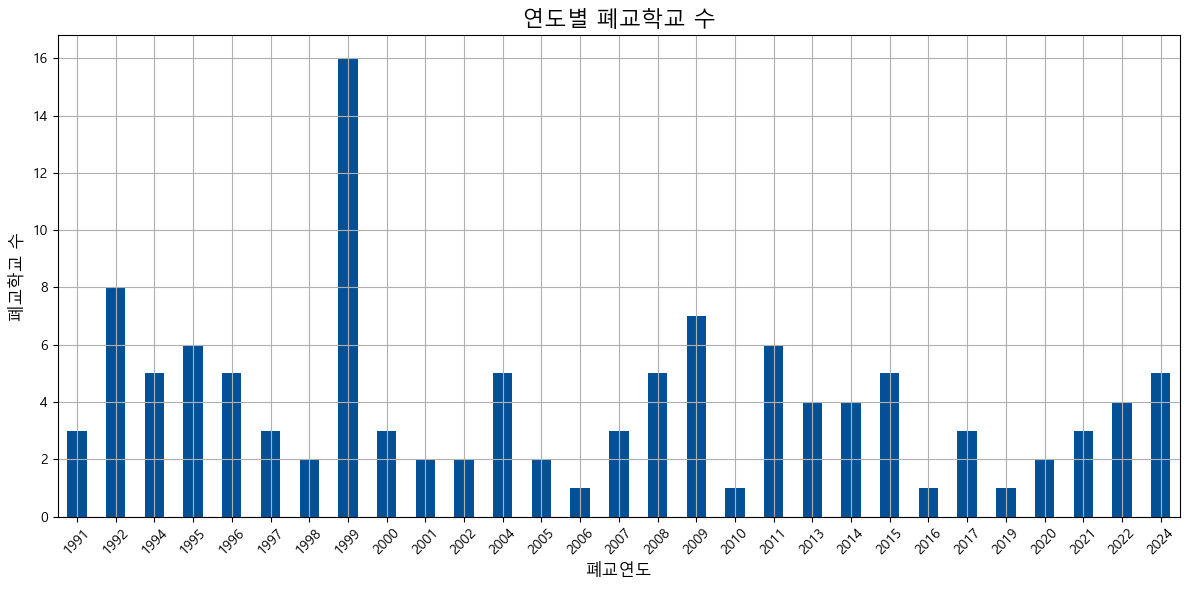

In [318]:
# 폐교연도별로 그룹화하여 폐교학교 수 계산
close_school_by_year = data_close_school.groupby('폐교연도')['폐교명'].count()

# 결과 시각화
plt.figure(figsize=(12, 6))
close_school_by_year.plot(kind='bar', color='#035096')

plt.title('연도별 폐교학교 수', fontsize=16)
plt.xlabel('폐교연도', fontsize=12)
plt.ylabel('폐교학교 수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

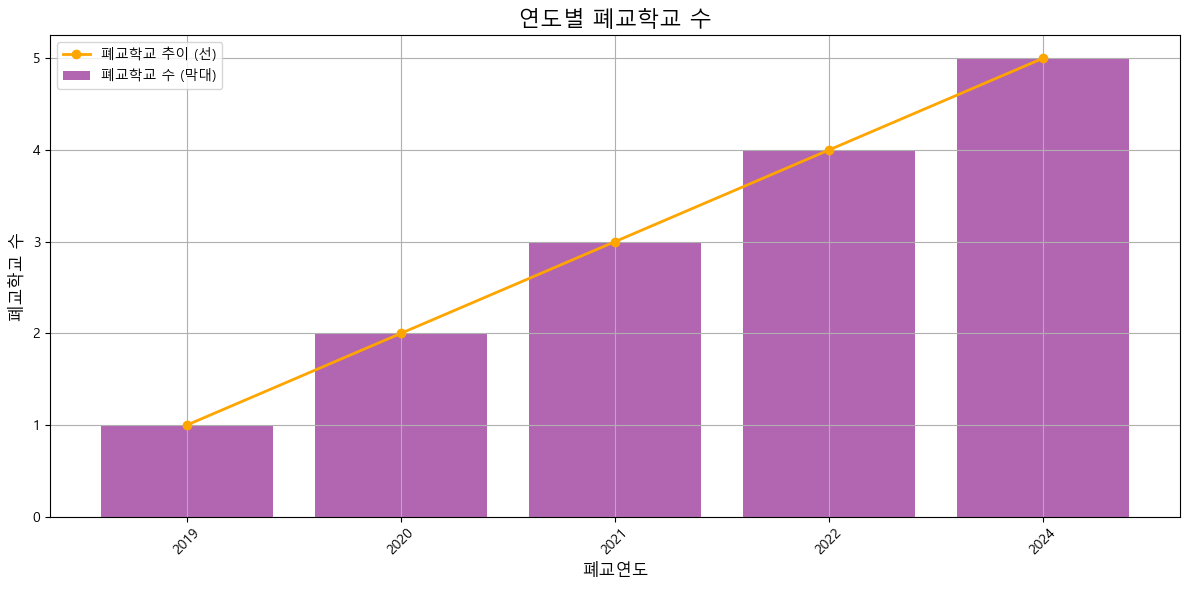

In [283]:
# 1) 폐교연도별로 그룹화하여 폐교학교 수 계산
close_school_by_year_last4 = data_close_school.groupby('폐교연도')['폐교명'].count()

# 2) 2019~2024 데이터 중 2023만 제거
close_school_by_year_last4_filtered = (
    close_school_by_year_last4.loc[2019:2024]
                               .drop(2023, errors='ignore')
)

# 3) x축에 사용할 인덱스(연도)와 값 준비
x_labels = close_school_by_year_last4_filtered.index      # [2019, 2020, 2021, 2022, 2024]
y_values = close_school_by_year_last4_filtered.values     # 각 연도별 폐교 수

# 4) x축 위치를 0부터 시작하는 연속된 정수 범위로 설정
x_positions = range(len(x_labels))   # [0, 1, 2, 3, 4] 등

# 5) 시각화
plt.figure(figsize=(12, 6))

# 막대 그래프: x_positions에 대해 그리되, 레이블만 x_labels로
plt.bar(
    x_positions,
    y_values,
    color='purple',
    label='폐교학교 수 (막대)',
    alpha=0.6
)

# 꺾은선 그래프
plt.plot(
    x_positions,
    y_values,
    color='orange',
    marker='o',
    label='폐교학교 추이 (선)',
    linestyle='-',
    linewidth=2
)

plt.title('연도별 폐교학교 수', fontsize=16)
plt.xlabel('폐교연도', fontsize=12)
plt.ylabel('폐교학교 수', fontsize=12)

# xticks를 실제 연도 레이블로 지정
plt.xticks(x_positions, x_labels, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [284]:
close_school_by_year_last4_filtered

폐교연도
2019    1
2020    2
2021    3
2022    4
2024    5
Name: 폐교명, dtype: int64

- 현재 초등학교 폐교 문제가 심함   
- 전남지역 초등학생 공급이 줄어들면 중학교, 고등학교도 많이 폐교할 것

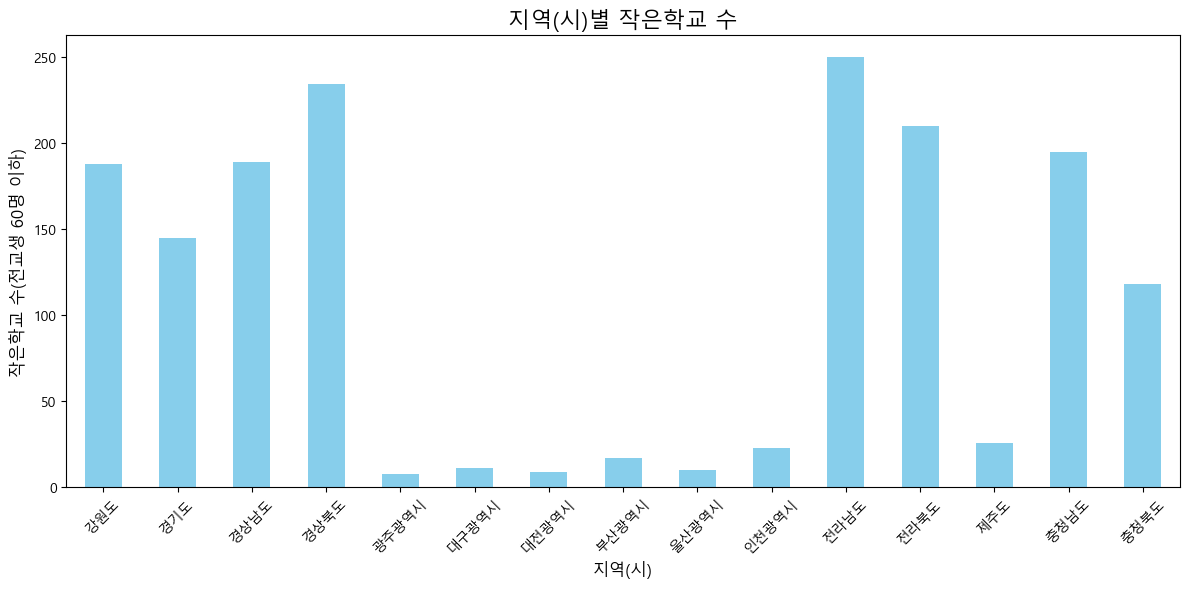

In [285]:
# 지역(시) 작은학교의 수 계산
small_school_count_by_region = data_total_school[data_total_school['작은학교여부'] == 1].groupby('지역(시)').size()

small_school_count_by_region.rename(
    index={
        '강원특별자치도': '강원도',
        '전북특별자치도': '전라북도',
        '제주특별자치도': '제주도'
    },
    inplace=True
)
# 지역별 작은학교 수 시각화
plt.figure(figsize=(12, 6))
small_school_count_by_region.plot(kind='bar', color='skyblue')

plt.title('지역(시)별 작은학교 수', fontsize=16)
plt.xlabel('지역(시)', fontsize=12)
plt.ylabel('작은학교 수(전교생 60명 이하)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- KT AIDLE 스쿨 목표 선정 : 전라남도 


사유: 작은학교가 제일 많음

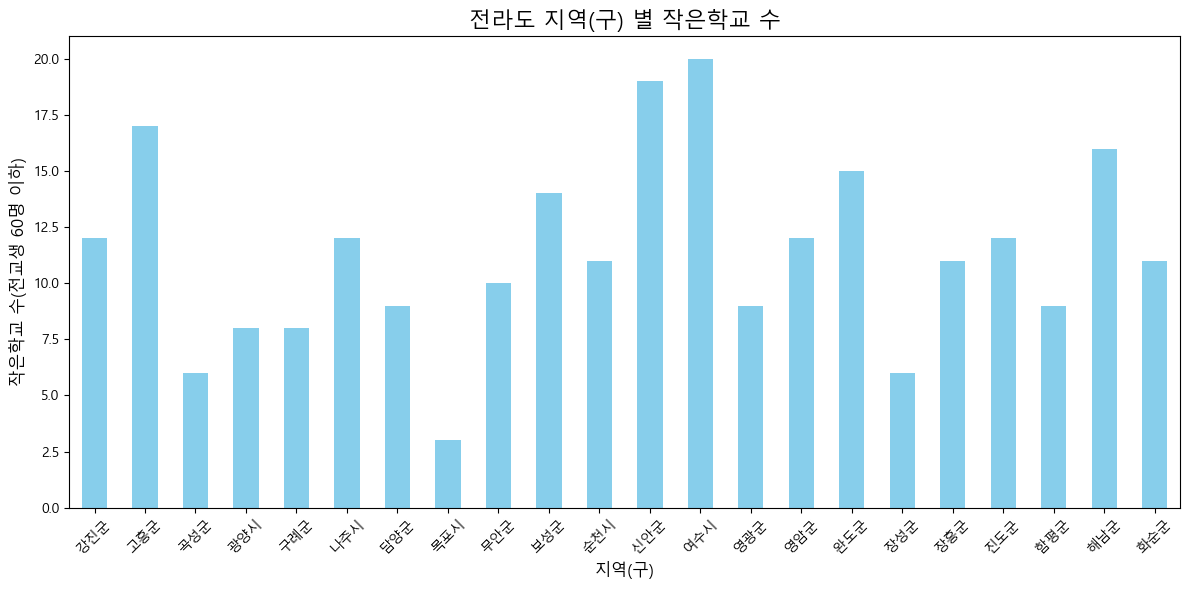

In [286]:
# 지역(시) 작은학교의 수 계산
small_school_count_by_region = data_target_school[data_target_school['작은학교여부'] == 1].groupby('지역(구)').size()

# 지역별 작은학교 수 시각화
plt.figure(figsize=(12, 6))
small_school_count_by_region.plot(kind='bar', color='skyblue')

plt.title('전라도 지역(구) 별 작은학교 수', fontsize=16)
plt.xlabel('지역(구)', fontsize=12)
plt.ylabel('작은학교 수(전교생 60명 이하)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

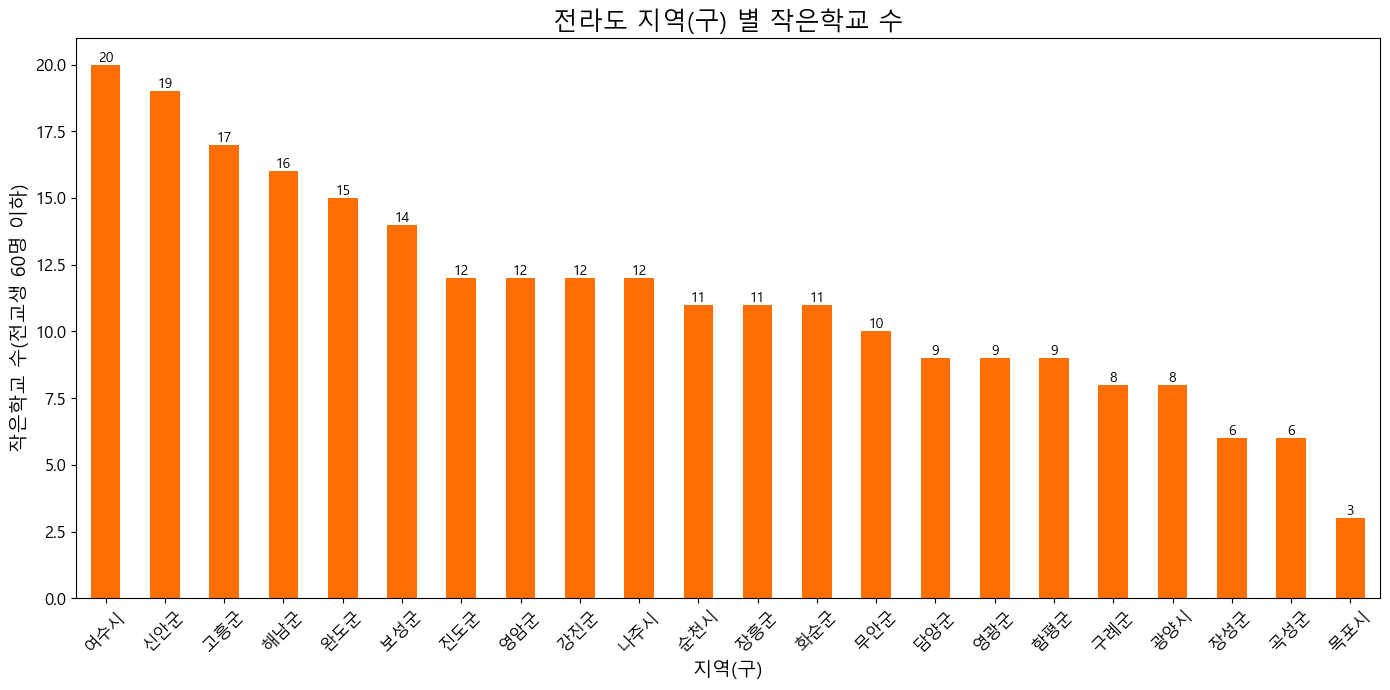

In [319]:
# 지역(구)별 작은학교 수 계산
small_school_count_by_region = data_target_school[data_target_school['작은학교여부'] == 1].groupby('지역(구)').size()

# 내림차순으로 정렬 (작은학교 수가 많은 순)
small_school_count_by_region = small_school_count_by_region.sort_values(ascending=False)

# 지역별 작은학교 수 시각화
plt.figure(figsize=(14, 7))
bars = small_school_count_by_region.plot(kind='bar', color='#FE6E00')

plt.title('전라도 지역(구) 별 작은학교 수', fontsize=18)
plt.xlabel('지역(구)', fontsize=14)
plt.ylabel('작은학교 수(전교생 60명 이하)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# 막대 위에 값 표시
for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.0f'),
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

- 특히 여수시는 제일 심각함 : 폐교된 학교도 많고 , 부지도 많이 비어있고 , 앞으로 없어질 가능성이 높음(작은학교 수가 가장 많음 )

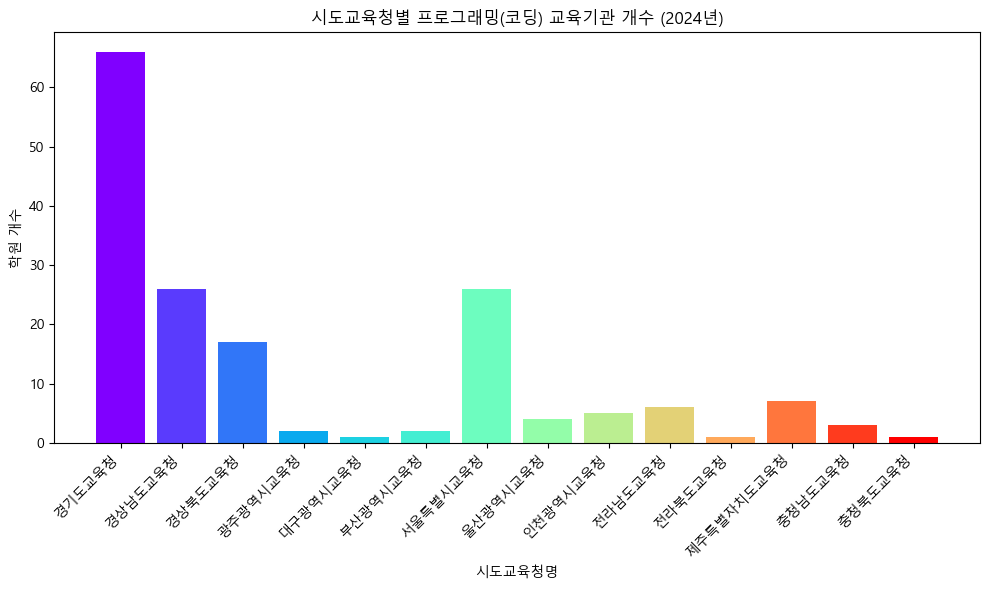

In [288]:
import matplotlib.cm as cm
# 1) 시도교육청명별 학원 개수 계산
edu_counts = (
    data_coding_academy.groupby('시도교육청명')['학원명']
    .count()
    .reset_index(name='학원 수')
)

# 2) 세종특별자치시교육청, 전북특별자치도교육청 제거
exclude_list = ['세종특별자치시교육청', '전북특별자치도교육청']
edu_counts_filtered = edu_counts[~edu_counts['시도교육청명'].isin(exclude_list)]

# 3) 컬러 팔레트 생성 (rainbow, tab20 등 원하는 대로 변경 가능)
num_bars = len(edu_counts_filtered)
colors = cm.rainbow(np.linspace(0, 1, num_bars))  # 0~1 사이를 균등분할

# 4) 시각화
plt.figure(figsize=(10, 6))
plt.bar(
    edu_counts_filtered['시도교육청명'],
    edu_counts_filtered['학원 수'],
    color=colors
)
plt.xlabel('시도교육청명')
plt.ylabel('학원 개수')
plt.title('시도교육청별 프로그래밍(코딩) 교육기관 개수 (2024년)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [289]:
# PowerBI용 데이터프레임 csv 저장
path = 'for_powerBI/'
data_total_human.to_csv(path+'data_total_human.csv', index=False)
data_close_school.to_csv(path+'data_close_school.csv', index=False)
data_total_school.to_csv(path+'data_total_school.csv', index=False)
data_target_school.to_csv(path+'data_target_school.csv', index=False)

### (1) 지역별 작은학교 지도에 좌표 찍을 수 있도록 데이터프레임 변환 및 csv파일 생성

In [290]:
path='origin_data/'

In [291]:
# 전남지역 초등학교 현황 (x,y좌표 포함)

file = '학교현황엑셀파일(초등학교).csv'
data_small_element_school_address = pd.read_csv(path+file)
data_small_element_school_address.head()

,번호,급,지역,기관명,홈페이지,우편번호,설립,구분,주소,전화,FAX,위도,경도
0,1415,초등학교,목포시,목포서산초등학교,http://mokposeosan.es.jne.kr,58758,공립,본교,"전라남도 목포시 유달로 28 (서산동,목포서산초등학교)",061-245-4725,061-245-4133,34.782094,126.374877
1,1414,초등학교,목포시,목포서산초등학교충무분교장,http://mokposeosan.es.jne.kr,58762,공립,분교,"전라남도 목포시 고하도길 91 (달동,목포서산초등학교충무분교)",061-246-2004,061-246-2044,34.762055,126.367400
2,1413,초등학교,목포시,목포서해초등학교,http://mokposeohae.es.jne.kr,58633,공립,본교,"전라남도 목포시 연산로 148 , 목포서해초등학교",061-279-5708,061-279-5709,34.810466,126.381102
3,1412,초등학교,목포시,목포석현초등학교,http://mpsh.es.jne.kr,58656,공립,본교,전라남도 목포시 옥암로 186번길 20 목포석현초등학교 (옥암동),061-285-9907,061-285-9906,34.814973,126.424503
4,1411,초등학교,목포시,목포신흥초등학교,http://mokposhinhung.es.jne.kr,58694,공립,본교,"전라남도 목포시 교육로 10 (상동,목포신흥초등학교)",061-281-7541,061-281-7543,34.799405,126.424659


In [292]:
# 1) data_small_element_school_address에서 필요한 컬럼들만 선택
df_small_address = data_small_element_school_address[["기관명", "주소", "우편번호", "위도", "경도"]]

# 2) data_target_school 에서 "작은학교여부 == 1"인 행만 필터링 후 필요한 컬럼만 선택
df_target_small = data_target_school.loc[data_target_school["작은학교여부"] == 1,
                                         ["학교명", "학생수(계)", "작은학교여부"]]

# 3) df_small_address(기관명)과 df_target_small(학교명)을 기준으로 병합
#    how="inner"는 두 데이터프레임 모두에 존재하는 키에 대해서만 조인합니다.
merged_df = pd.merge(df_small_address, 
                     df_target_small, 
                     left_on="기관명", 
                     right_on="학교명", 
                     how="inner")

# 결과 확인
merged_df

,기관명,주소,우편번호,위도,경도,학교명,학생수(계),작은학교여부
0,목포서산초등학교,"전라남도 목포시 유달로 28 (서산동,목포서산초등학교)",58758,34.782094,126.374877,목포서산초등학교,32,1
1,목포유달초등학교달리분교장,"전라남도 목포시 달리길157번길 35 (달동,유달초등학교달리분교)",58761,34.774928,126.313541,목포유달초등학교달리분교장,1,1
2,망운초등학교,"전라남도 무안군 망운면 망운로 34 (망운면,망운초등학교)",58534,35.016278,126.393733,망운초등학교,28,1
3,몽탄초등학교,"전라남도 무안군 몽탄면 몽탄로 878 (몽탄면,몽탄초교)",58546,34.929375,126.501500,몽탄초등학교,21,1
4,삼향북초등학교,"전라남도 무안군 삼향읍 원지산길 66 (삼향읍,삼향북초등학교)",58558,34.879642,126.419865,삼향북초등학교,39,1
...,...,...,...,...,...,...,...,...
249,의신초등학교모도분교장,"전라남도 진도군 의신면 모도길 12-3 (의신면,의동초등학교모도분교장)",58936,34.407755,126.355600,의신초등학교모도분교장,5,1
250,의신초등학교접도분교장,"전라남도 진도군 의신면 황모길 25-1 (의신면,접도초등학교)",58939,34.386179,126.295597,의신초등학교접도분교장,2,1
251,조도초등학교,"전라남도 진도군 조도면 창유1길 36-14 (조도면,조도초등학교)",58956,34.295819,126.049244,조도초등학교,36,1
252,조도초등학교거차분교장,"전라남도 진도군 조도면 서거차도1길 42 , 조도초등학교거차분교장",58958,34.252828,125.918046,조도초등학교거차분교장,2,1


## (2) 연도별 작은학교 추이 시각화 

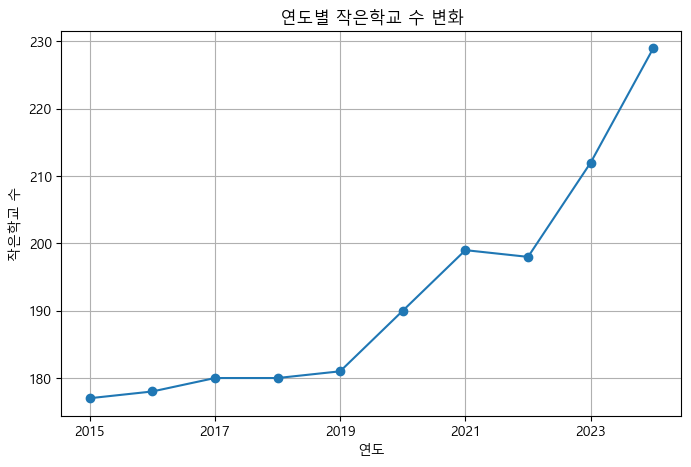

In [293]:
file= '24_(정보공개시스템) 최근 10년간(2014~2024)작은학교.csv'
data_visual = pd.read_csv(path+file)
data_visual.loc[data_visual['연도별'] == '학생수', '연도별'] = '작은학교 수'
data_visual = data_visual.set_index('연도별').T

data_visual.plot(y='작은학교 수', marker='o', legend=False, figsize=(8,5))
plt.title('연도별 작은학교 수 변화')
plt.xlabel('연도')
plt.ylabel('작은학교 수')
plt.grid(True)
plt.show()

In [294]:
merged_df.to_csv('for_powerBI/학교현황엑셀파일(초등학교_작은학교).csv', index=False)

# (6) 다변량 분석

-  x(독립변수): 수집한 데이터들(전남 지역별, 연도별 인구,토지,교육,사업체수 등의 빅데이터 데이터프레임)
-  y(종속변수): 폐교수 , 작은학교 수




## 1) 데이터셋에서 타겟(종속변수) 가져오기

- 1. 전처리된 데이터프레임들에서 연도별(2018~2023) 폐교수 , 작은학교 수
- 2. 전처리된 데이터프레임들에서 지역별(여수시...목포군) 폐교수 , 작은학교 수

### 1) 지역별

#### 1) 지역별 폐교 학교 수


In [295]:
# 폐교연도가 2023인 데이터만 필터링  < 없음
df_filtered = data_close_school[data_close_school['폐교연도'] == 2023]

# 시군구명별로 폐교 개수를 세기
df_count = df_filtered.groupby('시군구명').size().reset_index(name='폐교학교 수')

df_count

,시군구명,폐교학교 수


- 지역별로 보려고 했으나 2023년도에는 폐교학교 수가 없음 

#### 2) 지역별 작은학교 수

In [296]:
# 지역(구)별로 작은학교여부를 count
df_count_samll_school = data_target_school.groupby('지역(구)')['작은학교여부'].sum().reset_index(name='작은학교 수')

# 컬럼 명 변경
df_count_samll_school.rename(columns={'지역(구)': '지역'}, inplace=True)

df_count_samll_school

,지역,작은학교 수
0,강진군,12
1,고흥군,17
2,곡성군,6
3,광양시,8
4,구례군,8
5,나주시,12
6,담양군,9
7,목포시,3
8,무안군,10
9,보성군,14


- 전남지역 여수시> 신안군 > 고흥군 순으로 작은학교 수가 많다 

### 2) 연도별

#### 1) 연도별 폐교 학교 수

In [297]:

# 폐교연도가 2018년부터 2023년까지인 데이터만 필터링하여 개수 합산
df_filtered_years = data_close_school[data_close_school['폐교연도'].between(2002, 2023)]

# 폐교연도별로 개수 계산
df_year_count = df_filtered_years.groupby('폐교연도').size().reset_index(name='폐교학교 수')

# 컬럼 명 변경
df_year_count.rename(columns={'폐교연도': '연도'}, inplace=True)

df_year_count


,연도,폐교학교 수
0,2002,2
1,2004,5
2,2005,2
3,2006,1
4,2007,3
5,2008,5
6,2009,7
7,2010,1
8,2011,6
9,2013,4


## 2) 전남시 통계자료들 가져오기
- 2002~2023 년도  연도별 통계 총합 : corr_data_year
    - 2011년도 데이터가 없어서 이 경우 전년도(2010년) 후 년도(2012)년도 의 평균값으로 대체하여 결측치 저리  
- 2023년 전남시 지역별 통계 총합 : corr_data_area


In [298]:
def fill_missing_with_mean(df, columns):
    '''
    df = 데이터프레임
    columns = 결측치를 보간할 컬럼 리스트
    '''
    for col in columns:
        # 컬럼 기준 앞뒤 값의 평균으로 결측치 채우기
        df[col] = df[col].fillna(df[col].shift(1) + df[col].shift(-1) / 2)
    
    return df

### 1) 데이터 불러오기 

In [299]:
# 2023 전남 총 통계연보 데이터 가져오기 
corr_data_year= pd.read_csv('correlation_analysis/전라남도_연도별_총_통계연표_(2002~2023).csv')# 2002~ 2023
# 지역별
corr_data_area = pd.read_csv('correlation_analysis/전라남도_지역별_총_통계연표_(2023).csv')



In [300]:
# 결측치가 있는 컬럼 확인 
missing_cols = corr_data_year.columns[corr_data_year.isnull().any()].tolist()
# 
# missing_cols

corr_data_year = fill_missing_with_mean(corr_data_year, missing_cols)


In [301]:
corr_data_year.head()

,연도,토지면적(km),전남지역 구성비(%),행정구역 수(시+군),행정구역 수(시),행정구역 수(군),행정구역 수 (읍+면+동),행정구역 수 (읍),행정구역 수 (면),행정구역(동)행정 수,...,종합(평생직업 교육학원 학원수),합계(평생직업 교육학원 학원수),입시검정및보습(학교교과 교습학원 학원수),국제화(학교교과 교습학원 학원수),예능(학교교과 교습학원 학원수),특수교육(학교교과 교습학원 학원수),종합(학교교과 교습학원 학원수),정보(학교교과 교습학원 학원수),기타(학교교과 교습학원 학원수),합계(학교교과 교습학원 학원수)
0,2002,12037,100,22,5,17,240,26,165,69,...,0,0,0,0,980,0,0.0,0,0,2302.0
1,2003,12046,100,22,5,17,240,27,164,70,...,0,0,0,0,1057,0,0.0,0,0,2387.0
2,2004,12052,100,22,5,17,240,27,164,70,...,0,0,0,0,1033,0,0.0,0,0,2442.0
3,2005,12073,100,22,5,17,240,27,164,70,...,0,0,0,0,1033,0,0.0,0,0,2519.0
4,2006,12095,100,22,5,17,240,27,164,66,...,0,0,1121,203,1014,0,0.0,0,0,2547.0


### 2) 데이터 전처리
- 데이터프레임 병합
- 컬럼 명 통일 ,(Km , m) 단위 통일 

In [302]:
# 데이터프레임 병합

merged_corr_data_year = pd.merge(corr_data_year, df_year_count, on="연도", how="inner")

merged_corr_data_area = pd.merge(corr_data_area, df_count_samll_school, on="지역", how="inner")

# # (전처리) '-' 전부 0으로 대체
merged_corr_data_year=merged_corr_data_year.replace(' - ', 0)
merged_corr_data_year=merged_corr_data_year.replace('-', 0)
merged_corr_data_area=merged_corr_data_area.replace(' - ', 0)
merged_corr_data_area=merged_corr_data_area.replace('-', 0)

C:\Users\User\AppData\Local\Temp\ipykernel_13820\3554336909.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_corr_data_area=merged_corr_data_area.replace('-', 0)


In [303]:
merged_corr_data_year.head()
#merged_corr_data_area.head()

,연도,토지면적(km),전남지역 구성비(%),행정구역 수(시+군),행정구역 수(시),행정구역 수(군),행정구역 수 (읍+면+동),행정구역 수 (읍),행정구역 수 (면),행정구역(동)행정 수,...,합계(평생직업 교육학원 학원수),입시검정및보습(학교교과 교습학원 학원수),국제화(학교교과 교습학원 학원수),예능(학교교과 교습학원 학원수),특수교육(학교교과 교습학원 학원수),종합(학교교과 교습학원 학원수),정보(학교교과 교습학원 학원수),기타(학교교과 교습학원 학원수),합계(학교교과 교습학원 학원수),폐교학교 수
0,2002,12037,100,22,5,17,240,26,165,69,...,0,0,0,980,0,0.0,0,0,2302.0,2
1,2004,12052,100,22,5,17,240,27,164,70,...,0,0,0,1033,0,0.0,0,0,2442.0,5
2,2005,12073,100,22,5,17,240,27,164,70,...,0,0,0,1033,0,0.0,0,0,2519.0,2
3,2006,12095,100,22,5,17,240,27,164,66,...,0,1121,203,1014,0,0.0,0,0,2547.0,1
4,2007,12121,100,22,5,17,295,31,198,66,...,0,1217,242,992,0,0.0,0,0,2637.0,3


In [304]:
# '지역' 컬럼을 제외한 모든 컬럼을 int64로 변환
merged_corr_data_area = merged_corr_data_area.apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='integer') if x.name != '지역' else x)

merged_corr_data_area.dtypes



지역                   object
토지면적(km)              int16
전남지역 구성비(%)            int8
행정구역(시+군)              int8
행정구역(시)                int8
                      ...  
종합(학교교과 교습학원 학원수)      int8
정보(학교교과 교습학원 학원수)      int8
기타(학교교과 교습학원 학원수)      int8
합계(학교교과 교습학원 학원수)     int16
작은학교 수                 int8
Length: 91, dtype: object

## 3) 상관분석 수행 (지역별)
- target: 작은학교 수
- feature: 그외 모든 컬럼

In [305]:
category = '지역'
target = "작은학교 수"
# 작은학교 수를 제외한 모든 컬럼
features = merged_corr_data_area.columns.difference([target,category])

# 상관분석 수행
corr_matrix_small_school = merged_corr_data_area[features].corrwith(merged_corr_data_area[target])


c:\Users\User\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\User\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## 4) 상관분석 수행 (연도별)
- target: 폐교 학교 수
- feature: 그외 모든 컬럼

In [306]:
category = '연도'
target = "폐교학교 수"
# 작은학교 수를 제외한 모든 컬럼
features = merged_corr_data_year.columns.difference([target,category])

# 상관분석 수행
corr_matrix_close_school = merged_corr_data_year[features].corrwith(merged_corr_data_year[target])

## (5) 상관분석 결과 시각화

- p-value <= 0.05 and not NaN 인 상관분석 결과만 출력 

### (1) 지역별 작은학교 수

In [307]:
def numerical_numerical(df_origin, feature , target): # 숫자형 , 숫자형
    # 산점도 + 회귀분석 선 표기
    
    
    '''
    df_origin = 데이터프레임 원본본
    feature = 구분 데이터프레임의 컬럼명
    target  = 목표 데이터프레임의 컬럼명

    '''
    
    result = spst.pearsonr(df_origin[feature], df_origin[target])
    
    # p-value 가 0.05 이상이거나 nan 이면 결과를 출력하지 않음 
    if result[1] >= 0.05 or np.isnan(result[0]) or np.isnan(result[1]) :
        return 0
    else:
        sns.regplot(x=feature, y = target, data = df_origin)
        plt.grid()
        plt.show()
        print(f'상관계수 : {result[0]}, p-value : {result[1]}')
        print('='*100)

In [308]:
# 
high_corr = corr_matrix_small_school.index


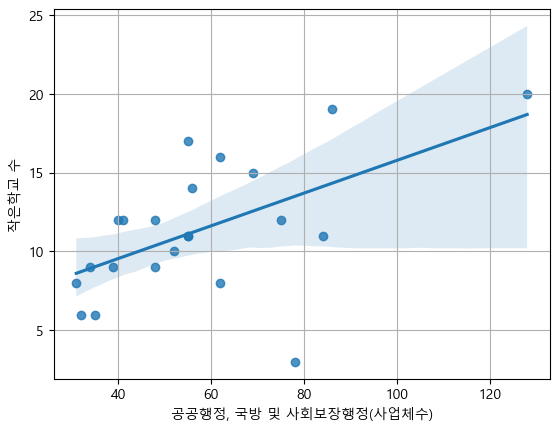

상관계수 : 0.5591107251042188, p-value : 0.006827763821666467


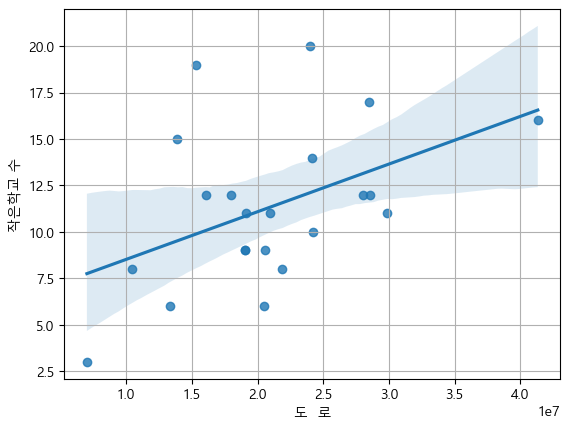

상관계수 : 0.45355434151129237, p-value : 0.03400014558961501


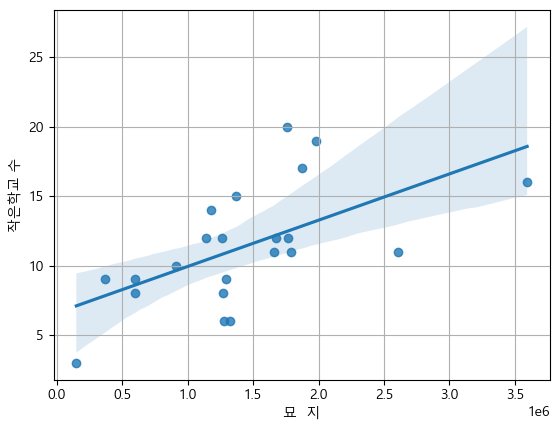

상관계수 : 0.587905547348663, p-value : 0.004008695190742829


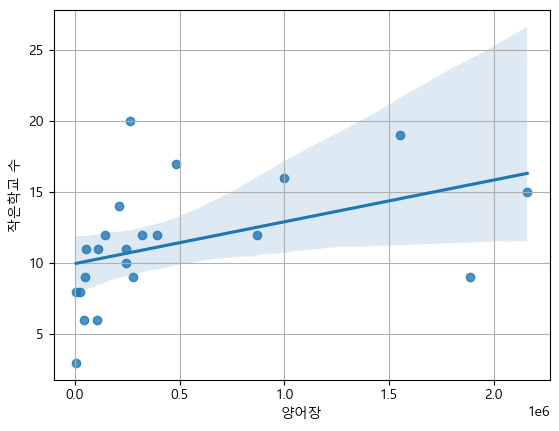

상관계수 : 0.4352241773560558, p-value : 0.04292681023162777


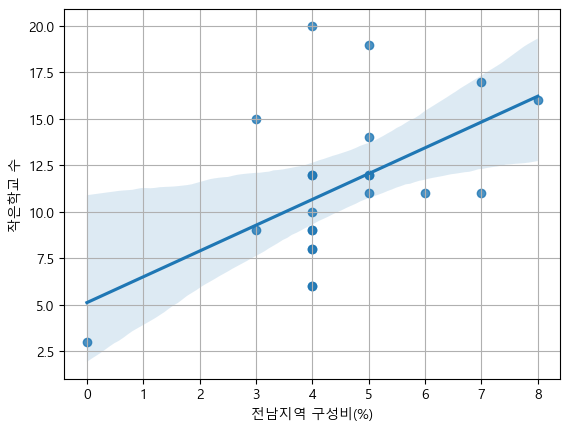

상관계수 : 0.5322567800621796, p-value : 0.010774856680062223


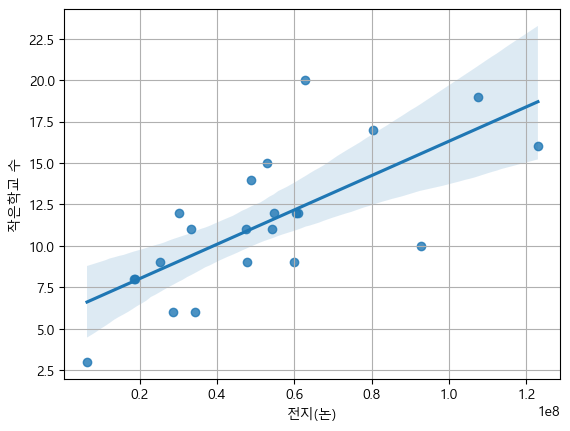

상관계수 : 0.7096248395287204, p-value : 0.00021666206752478327


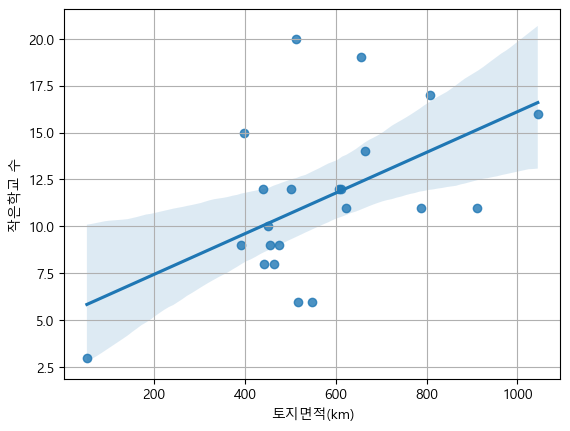

상관계수 : 0.5253359522096344, p-value : 0.01204931010347553


C:\Users\User\AppData\Local\Temp\ipykernel_13820\2032266738.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spst.pearsonr(df_origin[feature], df_origin[target])


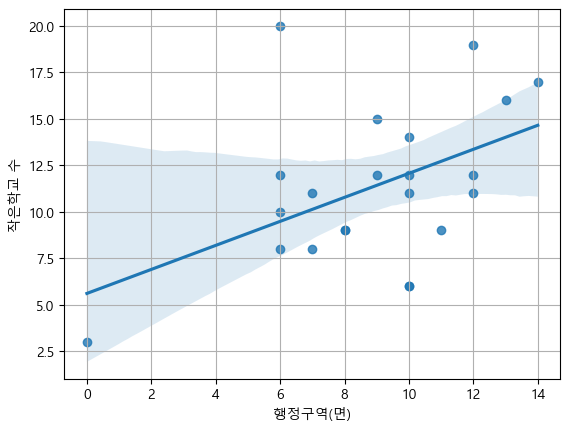

상관계수 : 0.4751505184624545, p-value : 0.025433993463430282


C:\Users\User\AppData\Local\Temp\ipykernel_13820\2032266738.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spst.pearsonr(df_origin[feature], df_origin[target])


In [309]:
target = '작은학교 수'
for feature in high_corr:
    numerical_numerical(merged_corr_data_area, feature, target)

C:\Users\User\AppData\Local\Temp\ipykernel_13820\3125450346.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = spst.pearsonr(valid_data[target_var], valid_data[var])
C:\Users\User\AppData\Local\Temp\ipykernel_13820\3125450346.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = spst.pearsonr(valid_data[target_var], valid_data[var])
C:\Users\User\AppData\Local\Temp\ipykernel_13820\3125450346.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # 레이아웃 조정


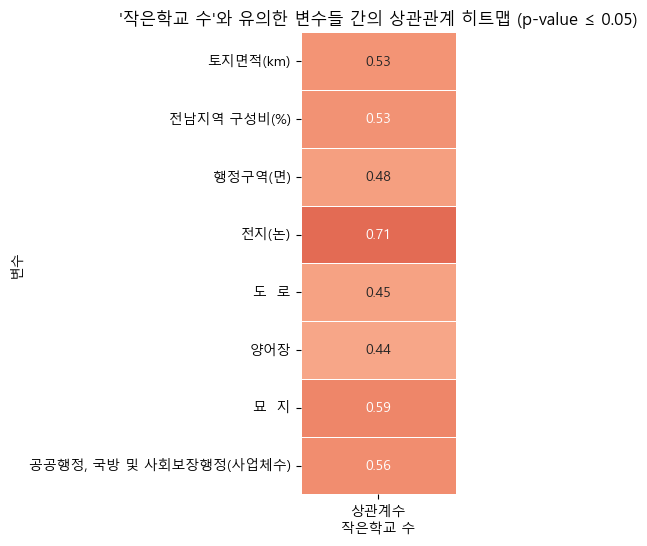

In [310]:
# 대상 변수
target_var = '작은학교 수'
dropc = '지역'
# 다른 변수들 목록 (대상 변수를 제외)
other_vars = merged_corr_data_area.columns.drop([target_var,dropc])

# 상관계수와 p-value를 저장할 리스트 초기화
corr_values = []
p_values = []

# 각 변수와 대상 변수 간의 상관계수 및 p-value 계산
for var in other_vars:
    # 결측치가 있는 경우 제거
    valid_data = merged_corr_data_area[[target_var, var]].dropna()
    if len(valid_data) < 2:
        # 데이터가 충분하지 않으면 상관계수와 p-value를 NaN으로 설정
        corr, p = np.nan, np.nan
    else:
        corr, p = spst.pearsonr(valid_data[target_var], valid_data[var])
    corr_values.append(corr)
    p_values.append(p)

# 결과를 데이터프레임으로 정리
corr_p_df = pd.DataFrame({
    '변수': other_vars,
    '상관계수': corr_values,
    'p-value': p_values
})

# p-value가 0.05 이하인 경우만 필터링
significant_corr = corr_p_df[corr_p_df['p-value'] <= 0.05]

# '작은학교 수'와의 상관관계를 인덱스로 설정
significant_corr.set_index('변수', inplace=True)

# 상관계수만 추출
target_corr = significant_corr[['상관계수']]

# 히트맵 그리기
plt.figure(figsize=(2, len(target_corr) * 0.5 + 2))  # 히트맵의 크기 설정

sns.heatmap(target_corr, 
            annot=True,              # 상관계수 표시
            cmap='coolwarm',         # 색상맵 설정
            linewidths=0.5,          # 셀 간의 선 두께
            vmin=-1, vmax=1,         # 상관계수 범위 설정
            center=0,                # 중앙값 설정
            cbar=False,              # 컬러바 숨기기
            fmt=".2f")               # 소수점 두 자리까지 표시

plt.title("'작은학교 수'와 유의한 변수들 간의 상관관계 히트맵 (p-value ≤ 0.05)")
plt.ylabel('변수')
plt.xlabel('작은학교 수')
plt.tight_layout()  # 레이아웃 조정
plt.show()

### (2) 연도별 폐교 학교 수

In [311]:
# 0.5 이상의 상관계수를 가진 index들만 필터링
high_corr = corr_matrix_close_school.index

In [312]:
target = '폐교학교 수'
for feature in high_corr:
    numerical_numerical(merged_corr_data_year, feature, target)

C:\Users\User\AppData\Local\Temp\ipykernel_13820\2032266738.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spst.pearsonr(df_origin[feature], df_origin[target])


#### (검증) p-value >= 0.05 , NaN 이라서 상관분석 결과가 나오지 않았나?

- A. 네, 전부 출력해본 결과 유의수준 이상이라서 상관분석의 결과가 유의미하지 않습니다. 
- 전남 통계연보의 자료들과 연도별 폐교학교 수 간 상관분석 결과가 유의미하지 않아서 채택할 수 없습니다.



In [313]:
# def numerical_numerical_nonfilter(df_origin, feature , target): # 숫자형 , 숫자형
#     # 산점도 + 회귀분석 선 표기
#     '''
#     df_origin = 데이터프레임 원본
#     feature = 구분 데이터프레임의 컬럼명
#     target  = 목표 데이터프레임의 컬럼명
#     '''
#     result = spst.pearsonr(df_origin[feature], df_origin[target])
#     sns.regplot(x=feature, y = target, data = df_origin)
#     plt.grid()
#     plt.show()
#     print(f'상관계수 : {result[0]}, p-value : {result[1]}')
#     print('='*100)

In [314]:
# target = '폐교학교 수'
# for feature in high_corr:
#     numerical_numerical_nonfilter(merged_corr_data_year, feature, target)

In [315]:
####